In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network architecture
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(20, activation='sigmoid')
        self.dense2 = tf.keras.layers.Dense(20, activation='sigmoid')
        self.dense2 = tf.keras.layers.Dense(20, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(20, activation='relu')
        self.out = tf.keras.layers.Dense(1)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.out(x)

# Initialize the model
model = PINN()

In [ ]:
# Generate synthetic data
x_data = np.linspace(0, 0.2, 11).reshape(-1, 1).astype(np.float32)
T_data = 10 + 100*x_data - 500*x_data**2  # Example quadratic temperature distribution
print(x_data)
print(T_data)
# Convert data to TensorFlow tensors
x_data_tensor = tf.convert_to_tensor(x_data, dtype=tf.float32)
T_data_tensor = tf.convert_to_tensor(T_data, dtype=tf.float32)
print(x_data_tensor)
print(T_data_tensor)

[[0.  ]
 [0.02]
 [0.04]
 [0.06]
 [0.08]
 [0.1 ]
 [0.12]
 [0.14]
 [0.16]
 [0.18]
 [0.2 ]]
[[10.      ]
 [11.8     ]
 [13.2     ]
 [14.2     ]
 [14.8     ]
 [15.      ]
 [14.8     ]
 [14.2     ]
 [13.200001]
 [11.799999]
 [ 9.999998]]
tf.Tensor(
[[0.  ]
 [0.02]
 [0.04]
 [0.06]
 [0.08]
 [0.1 ]
 [0.12]
 [0.14]
 [0.16]
 [0.18]
 [0.2 ]], shape=(11, 1), dtype=float32)
tf.Tensor(
[[10.      ]
 [11.8     ]
 [13.2     ]
 [14.2     ]
 [14.8     ]
 [15.      ]
 [14.8     ]
 [14.2     ]
 [13.200001]
 [11.799999]
 [ 9.999998]], shape=(11, 1), dtype=float32)


In [ ]:
def compute_physics_loss(model, x):
    with tf.GradientTape() as tape2:
        tape2.watch(x)
        with tf.GradientTape() as tape1:
            tape1.watch(x)
            T_pred = model(x)
        dT_dx = tape1.gradient(T_pred, x)
    d2T_dx2 = tape2.gradient(dT_dx, x)
    return tf.reduce_mean(tf.square(d2T_dx2))

In [ ]:
optimizer = tf.keras.optimizers.Adam()

# Custom training loop
for epoch in range(1000):
    with tf.GradientTape(persistent=True) as tape:
        T_pred = model(x_data_tensor)
        data_loss = tf.reduce_mean(tf.square(T_pred - T_data_tensor))
        physics_loss = compute_physics_loss(model, x_data_tensor)
        total_loss = data_loss + physics_loss

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.numpy()}, Data Loss: {data_loss.numpy()}, Physics Loss: {physics_loss.numpy()}")

Epoch 0, Loss: 182.6131591796875, Data Loss: 182.6131591796875, Physics Loss: 1.4385896918156504e-07
Epoch 100, Loss: 79.13604736328125, Data Loss: 79.13591003417969, Physics Loss: 0.00013764764298684895
Epoch 200, Loss: 14.509834289550781, Data Loss: 14.505776405334473, Physics Loss: 0.004057638347148895
Epoch 300, Loss: 3.298125982284546, Data Loss: 3.2855887413024902, Physics Loss: 0.012537333182990551
Epoch 400, Loss: 3.1367242336273193, Data Loss: 3.1234781742095947, Physics Loss: 0.013246121816337109
Epoch 500, Loss: 3.1351890563964844, Data Loss: 3.123079538345337, Physics Loss: 0.012109589762985706
Epoch 600, Loss: 3.133820056915283, Data Loss: 3.1228716373443604, Physics Loss: 0.010948444716632366
Epoch 700, Loss: 3.1325089931488037, Data Loss: 3.1226625442504883, Physics Loss: 0.009846384637057781
Epoch 800, Loss: 3.131274938583374, Data Loss: 3.122454881668091, Physics Loss: 0.00882002990692854
Epoch 900, Loss: 3.1301276683807373, Data Loss: 3.1222503185272217, Physics Loss:

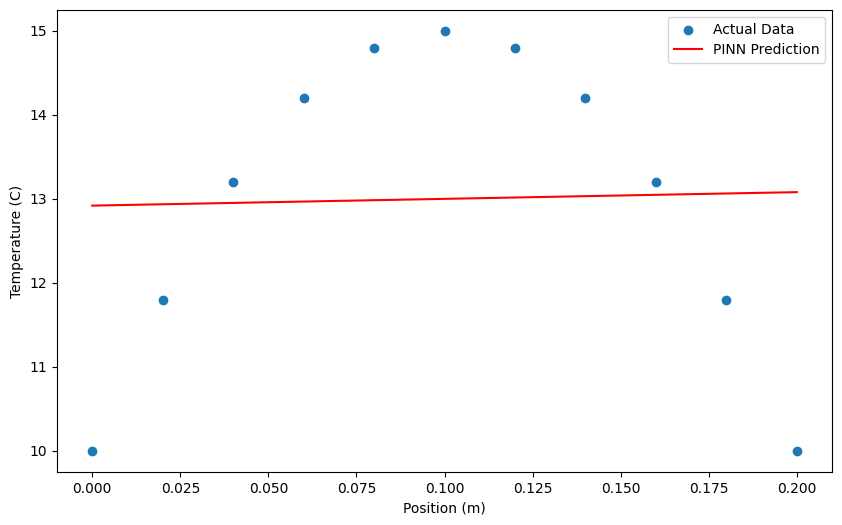

In [ ]:
# Predict temperatures using the trained model
T_pred = model(x_data_tensor)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x_data, T_data, label='Actual Data')
plt.plot(x_data, T_pred.numpy(), label='PINN Prediction', color='red')
plt.xlabel('Position (m)')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn

# Define the neural network
class HeatConductionNN(nn.Module):
    def __init__(self, num_neurons=20, num_layers=3):
        super().__init__()
        layers = [nn.Linear(1, num_neurons), nn.Tanh()]
        for _ in range(num_layers-1):
            layers += [nn.Linear(num_neurons, num_neurons), nn.Tanh()]
        layers.append(nn.Linear(num_neurons, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = HeatConductionNN()

# Define the physics-informed loss
def physics_informed_loss(model, x, T_actual):
    # Use automatic differentiation to compute the second derivative
    x.requires_grad = True
    T_pred = model(x)
    dT_dx = torch.autograd.grad(T_pred, x, grad_outputs=torch.ones_like(T_pred), create_graph=True)[0]
    d2T_dx2 = torch.autograd.grad(dT_dx, x, grad_outputs=torch.ones_like(dT_dx), create_graph=True)[0]

    # Loss for the differential equation
    pde_loss = torch.mean(d2T_dx2**2)

    # Loss for the data points
    data_loss = torch.mean((T_pred - T_actual)**2)

    return pde_loss + data_loss

# Training loop
T_data = [376.183183,	376.079104,	375.962007,	375.814418,	375.707068,	375.600435,	375.521479,	375.386663,	375.208900,	375.126933,	374.882827]

# Convert the actual temperature data to a PyTorch tensor
T_data_tensor = torch.tensor(T_data, dtype=torch.float32).reshape(-1, 1)

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
x_data = torch.linspace(0, 0.2, 11).reshape(-1, 1)
tolerance = 1e-1  # Set a threshold for early stopping
previous_loss = float('inf')  # Initialize previous loss to a large value
patience = 50  # Set how many epochs to wait after last time the monitored quantity improved
patience_counter = 0  # Counter for patience

for epoch in range(100000):
    optimizer.zero_grad()
    loss = physics_informed_loss(model, x_data, T_data_tensor)
    loss.backward()
    optimizer.step()

    loss_value = loss.item()
    print(f'Epoch {epoch}, Loss: {loss_value}')

    # Check for early stopping condition
    if abs(previous_loss - loss_value) < tolerance:
        patience_counter += 1
        print(f'Early Stopping Counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print('Early stopping triggered.')
            break
    else:
        patience_counter = 0  # Reset counter if the loss improved

    previous_loss = loss_value  # Update the loss for the next iteration

# Evaluate the model's performance after training
with torch.no_grad():  # Context manager that disables gradient calculation
    T_pred = model(x_data)
    mse = torch.mean((T_pred - T_data_tensor) ** 2)
    print(f'Final Mean Squared Error: {mse.item()}')

print(T_pred)
print(T_data)

Epoch 0, Loss: 141083.71875
Epoch 1, Loss: 139967.765625
Epoch 2, Loss: 138675.578125
Epoch 3, Loss: 137368.796875
Epoch 4, Loss: 136000.984375
Epoch 5, Loss: 134590.734375
Epoch 6, Loss: 133146.71875
Epoch 7, Loss: 131681.390625
Epoch 8, Loss: 130203.6328125
Epoch 9, Loss: 128719.46875
Epoch 10, Loss: 127233.0234375
Epoch 11, Loss: 125747.2734375
Epoch 12, Loss: 124264.5234375
Epoch 13, Loss: 122786.453125
Epoch 14, Loss: 121314.4296875
Epoch 15, Loss: 119849.53125
Epoch 16, Loss: 118392.6328125
Epoch 17, Loss: 116944.5
Epoch 18, Loss: 115505.6484375
Epoch 19, Loss: 114076.6328125
Epoch 20, Loss: 112657.84375
Epoch 21, Loss: 111249.6484375
Epoch 22, Loss: 109852.34375
Epoch 23, Loss: 108466.15625
Epoch 24, Loss: 107091.34375
Epoch 25, Loss: 105728.0546875
Epoch 26, Loss: 104376.46875
Epoch 27, Loss: 103036.671875
Epoch 28, Loss: 101708.796875
Epoch 29, Loss: 100392.90625
Epoch 30, Loss: 99089.078125
Epoch 31, Loss: 97797.375
Epoch 32, Loss: 96517.828125
Epoch 33, Loss: 95250.4453125
E

In [ ]:
import torch
import torch.nn as nn

# Define the neural network
class HeatConductionNN(nn.Module):
    def __init__(self, num_neurons=20, num_layers=3):
        super().__init__()
        layers = [nn.Linear(1, num_neurons), nn.Tanh()]
        for _ in range(num_layers-1):
            layers += [nn.Linear(num_neurons, num_neurons), nn.Tanh()]
        layers.append(nn.Linear(num_neurons, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = HeatConductionNN()

# Define the physics-informed loss
def physics_informed_loss(model, x, T_actual):
    # Use automatic differentiation to compute the second derivative
    x.requires_grad = True
    T_pred = model(x)
    # dT_dx = torch.autograd.grad(T_pred, x, grad_outputs=torch.ones_like(T_pred), create_graph=True)[0]
    # d2T_dx2 = torch.autograd.grad(dT_dx, x, grad_outputs=torch.ones_like(dT_dx), create_graph=True)[0]

    # # Loss for the differential equation
    # pde_loss = torch.mean(d2T_dx2**2)

    # Loss for the data points
    data_loss = torch.mean((T_pred - T_actual)**2)

    return data_loss

# Training loop
T_data = [376.183183,	376.079104,	375.962007,	375.814418,	375.707068,	375.600435,	375.521479,	375.386663,	375.208900,	375.126933,	374.882827]

# Convert the actual temperature data to a PyTorch tensor
T_data_tensor = torch.tensor(T_data, dtype=torch.float32).reshape(-1, 1)

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
x_data = torch.linspace(0, 0.2, 11).reshape(-1, 1)
tolerance = 1e-1  # Set a threshold for early stopping
previous_loss = float('inf')  # Initialize previous loss to a large value
patience = 50  # Set how many epochs to wait after last time the monitored quantity improved
patience_counter = 0  # Counter for patience

for epoch in range(100000):
    optimizer.zero_grad()
    loss = physics_informed_loss(model, x_data, T_data_tensor)
    loss.backward()
    optimizer.step()

    loss_value = loss.item()
    print(f'Epoch {epoch}, Loss: {loss_value}')

    # Check for early stopping condition
    if abs(previous_loss - loss_value) < tolerance:
        patience_counter += 1
        print(f'Early Stopping Counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print('Early stopping triggered.')
            break
    else:
        patience_counter = 0  # Reset counter if the loss improved

    previous_loss = loss_value  # Update the loss for the next iteration

# Evaluate the model's performance after training
with torch.no_grad():  # Context manager that disables gradient calculation
    T_pred = model(x_data)
    mse = torch.mean((T_pred - T_data_tensor) ** 2)
    print(f'Final Mean Squared Error: {mse.item()}')

print(T_pred)
print(T_data)

Epoch 0, Loss: 140991.859375
Epoch 1, Loss: 140448.484375
Epoch 2, Loss: 138581.1875
Epoch 3, Loss: 137282.765625
Epoch 4, Loss: 135959.359375
Epoch 5, Loss: 134663.109375
Epoch 6, Loss: 133262.015625
Epoch 7, Loss: 131807.96875
Epoch 8, Loss: 130362.2734375
Epoch 9, Loss: 128904.296875
Epoch 10, Loss: 127436.15625
Epoch 11, Loss: 125962.578125
Epoch 12, Loss: 124487.203125
Epoch 13, Loss: 123012.796875
Epoch 14, Loss: 121541.5234375
Epoch 15, Loss: 120075.046875
Epoch 16, Loss: 118614.65625
Epoch 17, Loss: 117161.5234375
Epoch 18, Loss: 115716.5
Epoch 19, Loss: 114280.3203125
Epoch 20, Loss: 112853.59375
Epoch 21, Loss: 111436.84375
Epoch 22, Loss: 110030.5078125
Epoch 23, Loss: 108634.96875
Epoch 24, Loss: 107250.5234375
Epoch 25, Loss: 105877.40625
Epoch 26, Loss: 104515.8828125
Epoch 27, Loss: 103166.1171875
Epoch 28, Loss: 101828.25
Epoch 29, Loss: 100502.421875
Epoch 30, Loss: 99188.71875
Epoch 31, Loss: 97887.2265625
Epoch 32, Loss: 96598.0234375
Epoch 33, Loss: 95321.1484375
Ep

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np

# Assuming `df` is your DataFrame loaded with pandas
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Load the data from CSV or other file type if needed
df = pd.read_csv('/content/drive/MyDrive/MTP_DEC/1_para.csv')
# Assuming the first 11 columns are the temperatures at each position
temperatures = torch.tensor(df.iloc[:, :11].values, dtype=torch.float32)
# Assuming the positions are fixed and known, e.g., 0, 0.02, ..., 0.2
positions = torch.linspace(0, 0.2, steps=11)

# Custom dataset to handle the pairing of positions and temperatures
class CustomDataset(Dataset):
    def __init__(self, positions, temperatures):
        self.positions = positions
        self.temperatures = temperatures

    def __len__(self):
        return self.temperatures.shape[0]

    def __getitem__(self, idx):
        position = self.positions
        temperature = self.temperatures[idx, :]
        return position, temperature

# Instantiate the custom dataset
dataset = CustomDataset(positions, temperatures)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)




# Instantiate the model
model = HeatConductionNN()





RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x11 and 1x20)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Define the neural network model
class HeatConductionNN(nn.Module):
    def __init__(self, num_neurons=20, num_layers=3):
        super(HeatConductionNN, self).__init__()
        self.num_neurons = num_neurons
        # The input layer now has 11 neurons, corresponding to 11 positions
        layers = [nn.Linear(11, num_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(num_neurons, num_neurons), nn.Tanh()]
        # The output layer has 11 neurons, one for each position
        layers.append(nn.Linear(num_neurons, 11))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x is expected to be of shape [batch_size, num_positions]
        return self.network(x)

# Load the data from CSV
df = pd.read_csv('/content/drive/MyDrive/MTP_DEC/1_para.csv')
# Assuming the first 11 columns are the temperatures at each position
temperatures = torch.tensor(df.values, dtype=torch.float32)
# Assuming the positions are fixed and known, e.g., 0, 0.02, ..., 0.2
positions = torch.linspace(0, 0.2, steps=11)  # Shape [11]

# Custom dataset to handle the pairing of positions and temperatures
class CustomDataset(Dataset):
    def __init__(self, positions, temperatures):
        self.positions = positions.unsqueeze(0)  # Add batch dimension
        self.temperatures = temperatures

    def __len__(self):
        return self.temperatures.shape[0]

    def __getitem__(self, idx):
        # Return the same positions for each sample alongside the corresponding temperatures
        return self.positions, self.temperatures[idx]

# Instantiate the custom dataset
dataset = CustomDataset(positions, temperatures)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Instantiate the model
model = HeatConductionNN()

# Define the physics-informed loss
def physics_informed_loss(model, x_batch, T_batch):
    # Ensure we can compute gradients with respect to positions
    x_batch.requires_grad = True

    # Predict temperatures for each position
    T_pred = model(x_batch)

    # Calculate gradients for the physics-informed part of the loss
    dT_dx = torch.autograd.grad(T_pred, x_batch, grad_outputs=torch.ones_like(T_pred), create_graph=True)[0]
    d2T_dx2 = torch.autograd.grad(dT_dx, x_batch, grad_outputs=torch.ones_like(dT_dx), create_graph=True)[0]

    # Loss for the differential equation (PDE loss)
    pde_loss = torch.mean(d2T_dx2**2)

    # Loss for the data points (data loss)
    data_loss = torch.mean((T_pred - T_batch)**2)

    # Total loss is the sum of PDE loss and data loss
    return pde_loss + data_loss

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
tolerance = 1e-1
previous_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(1000):  # Number of epochs may need to be adjusted
    for positions_batch, temperatures_batch in data_loader:
        optimizer.zero_grad()
        loss = physics_informed_loss(model, positions_batch, temperatures_batch)
        loss.backward()
        optimizer.step()

    # Early stopping condition
    with torch.no_grad():
        loss = physics_informed_loss(model, positions, temperatures)
    loss_value = loss.item()
    if abs(previous_loss - loss_value) < tolerance:
        patience_counter += 1
        if patience_counter > patience:
            print(f'Early stopping at epoch {epoch}, loss: {loss_value}')
            break
    else:
        patience_counter = 0
    previous_loss = loss_value

    if epoch % 100 == 0:  # Print the loss every 100 epochs
        print(f'Epoch {epoch}, Loss: {loss_value}')

# Evaluate the model after training
with torch.no_grad():
    T_pred = model(positions).reshape_as(temperatures)
    mse = nn.functional.mse_loss(T_pred, temperatures)
    print(f'Final MSE: {mse.item()}')


RuntimeError: The size of tensor a (11) must match the size of tensor b (12) at non-singleton dimension 2

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd

# Define the neural network model
class HeatConductionNN(nn.Module):
    def __init__(self, num_neurons=20, num_layers=3):
        super(HeatConductionNN, self).__init__()
        self.num_neurons = num_neurons
        # The input layer now has 11 neurons, corresponding to 11 positions
        layers = [nn.Linear(11, num_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(num_neurons, num_neurons), nn.Tanh()]
        # The output layer has 11 neurons, one for each position
        layers.append(nn.Linear(num_neurons, 11))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x is expected to be of shape [batch_size, num_positions]
        return self.network(x)

# Load the data from CSV
df = pd.read_csv('/content/drive/MyDrive/MTP_DEC/1_para.csv')
# Assuming the first 11 columns are the temperatures at each position
temperatures = torch.tensor(df.iloc[:, :11].values, dtype=torch.float32)
# Assuming the positions are fixed and known, e.g., 0, 0.02, ..., 0.2
positions = torch.linspace(0, 0.2, steps=11)  # Shape [11]

# Custom dataset to handle the pairing of positions and temperatures
class CustomDataset(Dataset):
    def __init__(self, positions, temperatures):
        self.positions = positions.unsqueeze(0)  # Add batch dimension
        self.temperatures = temperatures

    def __len__(self):
        return self.temperatures.shape[0]

    def __getitem__(self, idx):
        # Return the same positions for each sample alongside the corresponding temperatures
        return self.positions.expand(self.temperatures.size(0), -1), self.temperatures[idx]

# Instantiate the custom dataset
dataset = CustomDataset(positions, temperatures)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Instantiate the model
model = HeatConductionNN()
print(T_pred)
# Define the physics-informed loss
def physics_informed_loss(model, x_batch, T_batch):
    # Ensure we can compute gradients with respect to positions
    x_batch.requires_grad = True

    # Predict temperatures for each position
    T_pred = model(x_batch)

    # Calculate gradients for the physics-informed part of the loss
    dT_dx = torch.autograd.grad(T_pred, x_batch, grad_outputs=torch.ones_like(T_pred), create_graph=True)[0]
    d2T_dx2 = torch.autograd.grad(dT_dx, x_batch, grad_outputs=torch.ones_like(dT_dx), create_graph=True)[0]

    # Loss for the differential equation (PDE loss)
    pde_loss = torch.mean(d2T_dx2**2)

    # Loss for the data points (data loss)
    data_loss = torch.mean((T_pred - T_batch)**2)

    # Total loss is the sum of PDE loss and data loss
    return pde_loss + data_loss

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
tolerance = 1e-1
previous_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(1000):  # Number of epochs may need to be adjusted
    for positions_batch, temperatures_batch in data_loader:
        optimizer.zero_grad()
        loss = physics_informed_loss(model, positions_batch, temperatures_batch)
        loss.backward()
        optimizer.step()

    # Early stopping condition
    with torch.no_grad():
        loss = physics_informed_loss(model, positions, temperatures)
    loss_value = loss.item()
    if abs(previous_loss - loss_value) < tolerance:
        patience_counter += 1
        if patience_counter > patience:
            print(f'Early stopping at epoch {epoch}, loss: {loss_value}')
            break
    else:
        patience_counter = 0
    previous_loss = loss_value

    if epoch % 100 == 0:  # Print the loss every 100 epochs
        print(f'Epoch {epoch}, Loss: {loss_value}')

# Evaluate the model after training
with torch.no_grad():
    T_pred = model(positions.unsqueeze(0)).squeeze()  # Remove the batch dimension
    mse = nn.functional.mse_loss(T_pred, temperatures)
    print(f'Final MSE: {mse.item()}')

tensor([[375.0070],
        [375.0070],
        [375.0070],
        [375.0070],
        [375.0070],
        [375.0070],
        [375.0070],
        [375.0070],
        [375.0070],
        [375.0070],
        [375.0070]])


RuntimeError: The size of tensor a (1000) must match the size of tensor b (32) at non-singleton dimension 1

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd

# Define the neural network model
class HeatConductionNN(nn.Module):
    def __init__(self, num_neurons=20, num_layers=3):
        super(HeatConductionNN, self).__init__()
        self.num_neurons = num_neurons
        # The input layer now has 11 neurons, corresponding to 11 positions
        layers = [nn.Linear(11, num_neurons), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(num_neurons, num_neurons), nn.Tanh()]
        # The output layer has 11 neurons, one for each position
        layers.append(nn.Linear(num_neurons, 11))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x is expected to be of shape [batch_size, num_positions]
        return self.network(x)

# Load the data from CSV
df = pd.read_csv('/content/drive/MyDrive/MTP_DEC/1_para.csv')
# Assuming the first 11 columns are the temperatures at each position
temperatures = torch.tensor(df.iloc[:, :11].values, dtype=torch.float32)
# Assuming the positions are fixed and known, e.g., 0, 0.02, ..., 0.2
positions = torch.linspace(0, 0.2, steps=11)  # Shape [11]

# Custom dataset to handle the pairing of positions and temperatures
class CustomDataset(Dataset):
    def __init__(self, positions, temperatures):
        self.positions = positions.unsqueeze(0)  # Add batch dimension
        self.temperatures = temperatures

    def __len__(self):
        return self.temperatures.shape[0]

    def __getitem__(self, idx):
        # Return the same positions for each sample alongside the corresponding temperatures
        return self.positions.expand(self.temperatures.size(0), -1), self.temperatures[idx]

# Instantiate the custom dataset
dataset = CustomDataset(positions, temperatures)
data_loader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Instantiate the model
model = HeatConductionNN()

# Define the physics-informed loss
def physics_informed_loss(model, x_batch, T_batch):
    # Ensure we can compute gradients with respect to positions
    x_batch.requires_grad = True

    # Predict temperatures for each position
    T_pred = model(x_batch)

    # Calculate gradients for the physics-informed part of the loss
    dT_dx = torch.autograd.grad(T_pred, x_batch, grad_outputs=torch.ones_like(T_pred), create_graph=True)[0]
    d2T_dx2 = torch.autograd.grad(dT_dx, x_batch, grad_outputs=torch.ones_like(dT_dx), create_graph=True)[0]

    # Loss for the differential equation (PDE loss)
    pde_loss = torch.mean(d2T_dx2**2)

    # Loss for the data points (data loss)
    data_loss = torch.mean((T_pred - T_batch)**2)

    # Total loss is the sum of PDE loss and data loss
    return pde_loss + data_loss

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
tolerance = 1e-1
previous_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(1000):  # Number of epochs may need to be adjusted
    for positions_batch, temperatures_batch in data_loader:
        optimizer.zero_grad()
        loss = physics_informed_loss(model, positions_batch, temperatures_batch)
        loss.backward()
        optimizer.step()

    # Early stopping condition
    with torch.no_grad():
        loss = physics_informed_loss(model, positions.unsqueeze(0), temperatures)
    loss_value = loss.item()
    if abs(previous_loss - loss_value) < tolerance:
        patience_counter += 1
        if patience_counter > patience:
            print(f'Early stopping at epoch {epoch}, loss: {loss_value}')
            break
    else:
        patience_counter = 0
    previous_loss = loss_value

    if epoch % 100 == 0:  # Print the loss every 100 epochs
        print(f'Epoch {epoch}, Loss: {loss_value}')

# Evaluate the model after training
with torch.no_grad():
    T_pred = model(positions.unsqueeze(0)).squeeze()  # Remove the batch dimension
    mse = nn.functional.mse_loss(T_pred, temperatures)
    print(f'Final MSE: {mse.item()}')


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn